# Фаза 2 • Неделя 10 • Вторник
## Обработка естественного языка
#### Word2Vec • LSTM • Attention

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
#### Word2Vec
from gensim.models import Word2Vec
####
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
from collections import Counter

from torchmetrics.classification import BinaryAccuracy
from src.rnn_preprocessing import (
                                data_preprocessing, 
                                preprocess_single_string, 
                                padding, 
                                get_words_by_freq
                                )
from src.train_rnn import train_attention_lstm

## Загрузка и препроцессинг данных

Общая схема обычная: 
1. Загружаем данные
2. Столбец с отзывами предобрабатываем (стоп-слова, числа, теги – все гиперпараметр)
3. Обучаем `word2vec` на наших данных и создаем собственный `embedding`-слой из векторов `w2v`
4. Преобразуем слова в индексы и делаем `padding`
5. Разделяем на обучение и валидацию

In [2]:
df = pd.read_csv('data/imdb.csv')
reviews = df['review'].tolist()
preprocessed = [data_preprocessing(review) for review in reviews]

In [3]:
preprocessed[10]

'phil alien one quirky films humour based around oddness everything rather actual punchlinesat first odd pretty funny movie progressed didnt find jokes oddness funny anymoreits low budget film thats never problem pretty interesting characters eventually lost interesti imagine film would appeal stoner currently partakingfor something similar better try brother another planet'

In [4]:
corpus = [word for text in preprocessed for word in text.split()]
sorted_words = Counter(corpus).most_common()

In [5]:
sorted_words = get_words_by_freq(sorted_words, 200)
sorted_words[-10:]

[('loads', 201),
 ('myers', 201),
 ('walken', 201),
 ('failing', 201),
 ('honesty', 201),
 ('dozens', 201),
 ('superficial', 201),
 ('reunion', 201),
 ('vegas', 201),
 ('todd', 201)]

In [6]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
# vocab_to_int

In [7]:
vocab_to_int.keys()

dict_keys(['movie', 'film', 'one', 'like', 'good', 'even', 'would', 'time', 'really', 'see', 'story', 'much', 'well', 'get', 'great', 'bad', 'also', 'people', 'first', 'dont', 'movies', 'made', 'make', 'films', 'could', 'way', 'characters', 'think', 'watch', 'many', 'seen', 'two', 'character', 'never', 'love', 'acting', 'little', 'plot', 'best', 'know', 'show', 'life', 'ever', 'better', 'say', 'still', 'scene', 'end', 'man', 'scenes', 'something', 'go', 'back', 'real', 'im', 'watching', 'thing', 'doesnt', 'didnt', 'actors', 'years', 'actually', 'though', 'funny', 'makes', 'another', 'find', 'nothing', 'look', 'going', 'work', 'lot', 'new', 'every', 'old', 'us', 'part', 'cant', 'director', 'want', 'quite', 'thats', 'things', 'pretty', 'cast', 'seems', 'around', 'got', 'young', 'take', 'fact', 'world', 'enough', 'big', 'horror', 'thought', 'give', 'may', 'ive', 'however', 'without', 'long', 'saw', 'isnt', 'always', 'gets', 'right', 'music', 'original', 'must', 'almost', 'come', 'series',

In [8]:
# Конвертируем слова в индексы
reviews_int = []
for text in preprocessed:
    r = [vocab_to_int[word] for word in text.split() if vocab_to_int.get(word)]
    reviews_int.append(r)
print([i for i in reviews_int[0]])
print(preprocessed[0])

[3, 1792, 934, 56, 3185, 284, 347, 2997, 107, 478, 467, 19, 57, 3068, 3185, 50, 469, 180, 107, 545, 52, 1589, 41, 41, 2338, 1324, 274, 469, 3227, 244, 231, 351, 3185, 238, 2396, 932, 2460, 1234, 418, 2354, 1070, 2804, 296, 211, 3533, 418, 234, 2299, 222, 34, 126, 7, 45, 166, 1160, 41, 547, 91, 159, 154, 432, 2818, 698, 84, 1131, 2332, 968, 698, 1269, 698, 58, 846, 87, 19, 284, 43, 103, 3068, 1435, 2049, 286, 45, 1406, 174, 1321, 1110, 3185, 88, 211, 1931, 1943, 469, 469, 2774, 377, 496, 14, 140, 13, 627, 688, 539, 1070, 547, 435, 802, 1842, 1070, 440, 56, 3185, 98, 300, 3566, 3085, 14, 1073, 3822, 389]
one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section priso

Формируем вход для Word2Vec – это вложенный список формата: 

```python
[
    ['это', 'первый', 'отзыв'],
    ['это', 'второй', 'отзыв']
]
```

In [9]:
len(preprocessed)

50000

In [10]:
w2v_input = []
for review in preprocessed:
    cur_review = []
    for word in review.split():
        if vocab_to_int.get(word):
            cur_review.append(word)
    w2v_input.append(cur_review)
print(len(w2v_input))

50000


In [11]:
# вход для модели w2v – список списков слов, составляющих один отзыв о фильме
VOCAB_SIZE = len(vocab_to_int) + 1  # add 1 for the padding token
EMBEDDING_DIM = 64 # embedding_dim 

In [12]:
# Обучим Word2Vec
wv = Word2Vec(
    min_count=1, # минимальная встречаемость в корпусе 
    vector_size=EMBEDDING_DIM # размерность вектора для слова
    )
wv.build_vocab(w2v_input)
print(f'Total reviews: {wv.corpus_count}')

Total reviews: 50000


In [13]:
# train word vectors
wv.train(
    corpus_iterable=w2v_input, 
    total_examples=wv.corpus_count, 
    epochs=10
    )

(42382032, 45274060)

In [14]:
# Похожесть слов
print(wv.wv.similarity('film', 'movie'))
print(wv.wv.similarity('film', 'car'))
print(wv.wv.similarity('cat', 'dog'))

# Близкие слова
print(wv.wv.similar_by_word('movie'))

0.7828623
-0.21470839
0.76721096
[('film', 0.7828621864318848), ('moviei', 0.7498178482055664), ('flick', 0.6619417071342468), ('movies', 0.6439246535301208), ('really', 0.5846030712127686), ('moviethe', 0.5708484053611755), ('thing', 0.5701989531517029), ('actually', 0.5382648706436157), ('think', 0.5292170643806458), ('honestly', 0.527561604976654)]


In [15]:
# Создаем слой эмбеддинга
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Бежим по всем словам словаря: если слово есть, достаем его вектор
# если слова нет, то распечатываем его и пропускаем
for word, i in vocab_to_int.items():
    try:
        embedding_vector = wv.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError as e:
        pass
        print(f'{e}: word: {word}')
        
# Создаем предобученный эмбеддинг – этот слой в нашей сети обучаться не будет
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
print(f'Number of words x EMEDDING_DIM: {embedding_matrix.shape}')

Number of words x EMEDDING_DIM: (3914, 64)


In [16]:
padded = padding(review_int=reviews_int, seq_len=64)
print(padded[5])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  135 3585  388    1   11 3366  917  241
   34  106   75  367   31  114  133   61  720  138  817 1552  397 1793
    3  245 2011  466 2857  223  406    4  349   65  144   29 2684  486
  583 1314   92  711 2489 3487 3101    1]


In [17]:
# train_test split + label encoding 
X_train, X_valid, y_train, y_valid = train_test_split(
    np.array(padded),
    pd.get_dummies(
        df['sentiment'], 
        drop_first=True
    ).values.astype('int'), test_size=0.2, random_state=1)

In [18]:
BATCH_SIZE = 64

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE)

In [19]:
# посмотрим, что внутри
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: BATCH_SIZE x SEQ_LEN', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y[:10])

Sample input size: BATCH_SIZE x SEQ_LEN torch.Size([64, 64])
Sample input: 
 tensor([[   0,    0,    0,  ...,   15, 2298, 3218],
        [ 259,   73, 1071,  ...,   70,   26,   10],
        [   0,    0,    0,  ...,  736, 1321,   24],
        ...,
        [   0,    0,    0,  ...,  104,   15,  417],
        [  19,  139,  154,  ...,  195,  139,   41],
        [   0,    0,    0,  ...,   10,  320,  398]])
Sample input: 
 tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


In [20]:
device = 'cpu' #cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
HIDDEN_SIZE = 32

In [22]:
class ConcatAttention(nn.Module):
    def __init__(
            self, 
            hidden_size: int = HIDDEN_SIZE
            ) -> None:
        
        super().__init__()
        self.hidden_size = hidden_size
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.align  = nn.Linear(hidden_size * 2, hidden_size)
        self.tanh   = nn.Tanh()

    def forward(
            self, 
            lstm_outputs: torch.Tensor, # BATCH_SIZE x SEQ_LEN x HIDDEN_SIZE
            final_hidden: torch.Tensor  # BATCH_SIZE x HIDDEN_SIZE
            ) -> Tuple[torch.Tensor, torch.Tensor]:
        
        att_weights = self.linear(lstm_outputs)
        # print(f'After linear: {att_weights.shape, final_hidden.unsqueeze(2).shape}')
        att_weights = torch.bmm(att_weights, final_hidden.unsqueeze(2))
        # print(f'After bmm: {att_weights.shape}')
        att_weights = F.softmax(att_weights.squeeze(2), dim=1)
        # print(f'After softmax: {att_weights.shape}')
        cntxt       = torch.bmm(lstm_outputs.transpose(1, 2), att_weights.unsqueeze(2))
        # print(f'Context: {cntxt.shape}')
        concatted   = torch.cat((cntxt, final_hidden.unsqueeze(2)), dim=1)
        # print(f'Concatted: {concatted.shape}')
        att_hidden  = self.tanh(self.align(concatted.squeeze(-1)))
        # print(f'Att Hidden: {att_hidden.shape}')
        return att_hidden, att_weights

# Test on random numbers
ConcatAttention()(torch.randn(BATCH_SIZE, 128, HIDDEN_SIZE), torch.randn(BATCH_SIZE, HIDDEN_SIZE))[1].shape

torch.Size([64, 128])

In [23]:
SEQ_LEN = 32

In [24]:
class LSTMConcatAttention(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # self.embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_SIZE, batch_first=True)
        self.attn = ConcatAttention(HIDDEN_SIZE)
        self.clf = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, 128),
            nn.Dropout(),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        embeddings = self.embedding(x)
        outputs, (h_n, _) = self.lstm(embeddings)
        att_hidden, att_weights = self.attn(outputs, h_n.squeeze(0))
        out = self.clf(att_hidden)
        return out, att_weights

In [25]:
model_concat = LSTMConcatAttention()
DEVICE='cpu'
criterion = nn.BCEWithLogitsLoss()
optimizer_concat = torch.optim.RMSprop(model_concat.parameters(), lr=0.001)

metric = BinaryAccuracy() #BinaryAccuracy().to(device)

In [26]:
train_losses, val_losses, train_metric, val_metric, rnn_time = train_attention_lstm(
    1, model_concat, train_loader, valid_loader, optimizer_concat, criterion, metric
)

Epoch 1
train_loss : 0.3780 val_loss : 0.3389
train_accuracy : 0.83 val_accuracy : 0.85


In [27]:
vocab_to_int['<pad>'] = 0

In [28]:
int_to_vocab = {j:i for i, j in vocab_to_int.items()}

In [29]:
def plot_and_predict(review: str, SEQ_LEN: int, model: nn.Module):
    """Predict class and draw word attention scores 

    Args:
        review (str): Review text
        SEQ_LEN (int): sequence length
        model (nn.Module): trained model
    """
    preprocessed = data_preprocessing(review) # preprocess string
    inp = preprocess_single_string(review, SEQ_LEN, vocab_to_int)
    model.eval()
    with torch.inference_mode():
        pred, att_scores = model(inp.long().unsqueeze(0))
    plt.figure(figsize=(4, 8))
    print(f'Prepocessed string: {preprocessed}')
    print(f'Prediction {pred.sigmoid().item():.3f}')
    plt.barh(np.arange(len(inp)), att_scores.detach().cpu().numpy()[0])
    plt.yticks(
        ticks = np.arange(len(inp)), 
        labels = [int_to_vocab[x.item()] for x in inp]
        );

Prepocessed string: good interesting film
Prediction 0.869


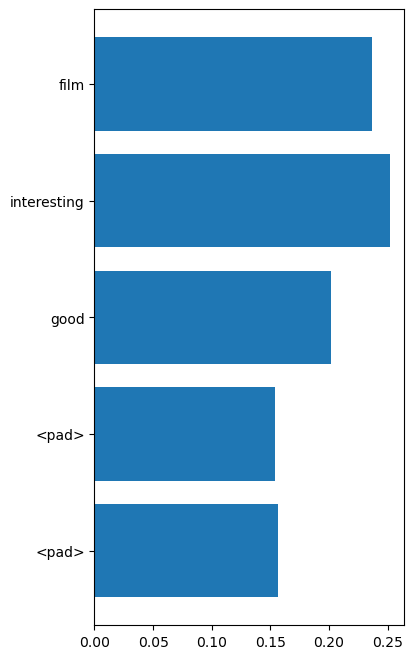

In [30]:
review = 'Very good and interesting film'
plot_and_predict(
    review = review, 
    SEQ_LEN=len(review.split()),
    model = model_concat
)
